In [109]:
# LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import itertools as it

from sklearn.metrics import silhouette_score
from sklearn.preprocessing import RobustScaler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from _nmf_ACCSLP import NMF_ACCSLP

sns.set_theme(style="darkgrid")


In [110]:
# CONSTANTS 
WEIGHT_THRESHOLD = 5

In [111]:
pd.options.display.width = 0
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',500)

In [112]:
def show_kmeans_clusters(data, x, y, hue, kmeans, title):
    plt.style.use("fivethirtyeight")
    plt.figure(figsize=(8, 8))
    
    scat = sns.scatterplot(
        data=data,
        x=x,
        y=y,
        hue=hue,
        palette="Set2",
    )
    
    scat.set_title(title)
    
    # Obtener los centroides
    centroids = kmeans.cluster_centers_
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    
    # Graficar los centroides
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
    
    plt.show()

In [113]:
def build_community_information_matrix(cluster_assignments):
    
    # Crear la matriz de membresía
    num_nodes = len(cluster_assignments)

    membership_matrix = np.zeros((num_nodes, num_nodes))

    for i in range(num_nodes):
        for j in range(num_nodes):
            # Verificar si los elementos pertenecen al mismo cluster
            if cluster_assignments[i] == cluster_assignments[j]:
                membership_matrix[i, j] = 1
    return membership_matrix

In [114]:
def draw_elbow_method_to_get_optimum_n_clusters(features, kmeans_kwargs):
    # elbow method to select k value (number of clusters)
    # A list holds the SSE values for each k
    
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(features)
        sse.append(kmeans.inertia_)
    
    plt.style.use("fivethirtyeight")
    plt.plot(range(1, 11), sse)
    plt.xticks(range(1, 11))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()
    
def draw_silhouette_score_to_get_optimum_n_clusters(features, kmeans_kwargs):
    # silhouette coefficients method to select k value (number of clusters)
    # A list holds the silhouette coefficients for each k
    silhouette_coefficients = []
    
    # Notice you start at 2 clusters for silhouette coefficient
    for k in range(2, 11):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(features)
        score = silhouette_score(features, kmeans.labels_)
        silhouette_coefficients.append(score)
    
    plt.style.use("fivethirtyeight")
    plt.plot(range(2, 11), silhouette_coefficients)
    plt.xticks(range(2, 11))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()


In [115]:
# Applying k-means algorithm 
def apply_kmeans(features, n_clusters, kmeans_kwargs, x, y, feature_names):

    k = n_clusters
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(features)
    kmeans_df =  pd.DataFrame(
        features,
        columns=feature_names
    )

    kmeans_df["predicted_cluster"] = kmeans.labels_

    show_kmeans_clusters(data=kmeans_df, kmeans=kmeans, x=x,
        y=y, hue="predicted_cluster",
            title="Clustering results")

    return build_community_information_matrix(cluster_assignments=kmeans_df["predicted_cluster"])

In [116]:
def apply_rbf_to_get_similarity(features, gamma=1):
    rbf_matrix = rbf_kernel(features, gamma=gamma)  # Ajusta gamma según tu necesidad
    return rbf_matrix

In [117]:
def compareNodes(f_list, s_list):
    """
        Function that returns the number of users that have interact with both items
        Funcion que devuelve el numero de usuarios que han interactuado con ambos items
    """
    weight = len(np.intersect1d(f_list, s_list))
    
    return weight
    
def createLinks(prob_us_set, nodes, threshold):
    """
        Function that creates graph links with the information about the set. The weight has to be grater or equal to threshold.
        
        Funcion que crea los enlaces del grafo a partir de la informacion contenida en el conjunto que se le
        pasa a la funcion. El peso tiene que ser mayor o igual al umbral.
        
        Format of links list -> [(Node1, Node2, weight), ......]
    """
    result = list()  
    
    # hago todas las posibles combinaciones de problemas
    for fst, snd in it.combinations(nodes, 2):
        # obtengo el peso pasando la lista de usuarios que ha hecho cada problema
        weight = compareNodes(prob_us_set[fst], prob_us_set[snd])

        # If at least two users have been interacted with the same two items, then add link to list, else, omit the interactions.
        if weight >= threshold:
            result.append((fst, snd))
            
    return result

In [118]:
def create_graph_nx(list_nodes, list_links):
    """
        Function that creates a graph with the format from NetworkX 
        
        Funcion que crea un grafo de tipo Graph de la libreria NetworkX
        Construccion del grafo: http://networkx.readthedocs.io/en/networkx-1.11/tutorial/tutorial.html#what-to-use-as-nodes-and-edges
    """
    grafo = nx.Graph() # creo la variable grafo

    # incluyo los nodos del grafo 
    grafo.add_nodes_from(list_nodes)

    # se incluyen las tuplas de enlaces con el peso del enlace
    # es una lista de la forma [(Nodo1, Nodo2, peso), ......]
    grafo.add_edges_from(list_links)

    return grafo

def build_adjacency_matrix(graph, list_nodes):
    return nx.to_numpy_array(graph, nodelist=list_nodes)

In [119]:
def main_process(df_items, df_interactions):
    # Note: Is important be consistent with the order of the items in the three matrices

    # BUILDING ADJACENCY MATRIX
    
    # Sea G (V, E1, A), donde V es el conjunto de vertices, conformado por V1 los vertices con aristas E1, y
    # V2 los vertices aislados. V1 U V2 = V, V1 inter V2 = 0. E1 es el conjunto de aristas de los vertices V1.
    # A es una matriz de atributos de dimension m x n, donde m son los items y n son el numero de atributos.

    # 1. Recuperar las interacciones de los usuarios con los items desde la base de datos. Bajo la siguiente
    # estructura
    # user | item | timestamp
    
    # 2. Recuperar todos los items (nodes) de la base de datos
    nodes = df_items.id.unique()
 
    # 3. I create a dictionary: keys are the items, and values are the list of users that are interacted with this item
    grouped = df_interactions.groupby('item')['user'].apply(list)

    links = list()
    
    if not grouped.empty:

        nodes_with_interaction = df_interactions.item.unique()

        # 4. create the links with the suitable format for nx
        links = createLinks(grouped, nodes_with_interaction, WEIGHT_THRESHOLD)
 
    # 5. I create the graph
    graph = create_graph_nx(nodes, links)

    # 6. Build adjacency matrix
    adjacency_matrix = build_adjacency_matrix(graph, list_nodes=nodes)

    # GETTING DATA TO BUILD THE COMMUNITY MEMBERSHIP INFORMATION MATRIX AND ATTRIBUTE SIMILARITY MATRIX

    column_names = ["Actual_price_log", "Category_name_encoded_log"]
    features = df_items[column_names]

    scaler = RobustScaler()
    scaled_features = scaler.fit_transform(features)

    # BUILDING COMMUNITY MEMBERSHIP INFORMATION MATRIX
    
    # Applying K-MEANS to build commnunity membership information matrix
    kmeans_kwargs = {
        "init": "k-means++",
        "n_init": 10,
        "max_iter": 300,
    }

    # Applying k-means clustering
    # draw_elbow_method_to_get_optimum_n_clusters(scaled_features, kmeans_kwargs)
    # draw_silhouette_score_to_get_optimum_n_clusters(scaled_features, kmeans_kwargs)

    # n_clusters must be selected according to elbow_method and silhouette_score
    n_clusters = 2 
    community_matrix = apply_kmeans(scaled_features, n_clusters, kmeans_kwargs,
            x=column_names[0], y=column_names[1], feature_names=column_names)

    # BUILDING THE ATTRIBUTE SIMILARITY MATRIX
    
    # Applying RBF to build attribute similarity matrix
    similarity_matrix = apply_rbf_to_get_similarity(features=scaled_features)   

    train_test_split

    

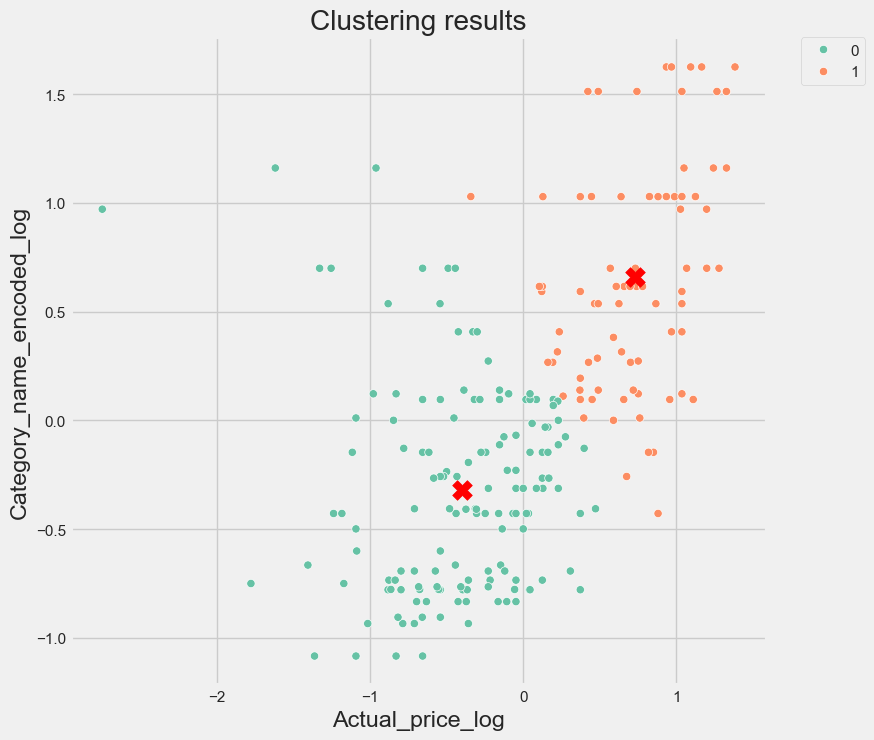

(231, 231)
(231, 231)
(231, 231)


In [120]:
df_items = pd.read_csv('./../datasets/reduced_electronic_products.csv')
df_interactions = pd.read_csv('./../datasets/interactions.csv')

main_process(df_items, df_interactions)